In [1]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.6-cp310-cp310-linux_x86_64.whl size=2746317 sha256=a8ba5fd5d8fef9e8285d5180cb8945d2f962e15366c140292cca9f028009a17a
  Stored in directory: /root/.cache/pip/wheels/4c/ca/89/8fc1fb1c620afca13bb41c630b1f948bbf446e0aaa4b762e10
Successfully built mpi4py


In [5]:
!mpic++ ping_pong_1.cpp -o test

In [6]:
!mpirun -n 2 --allow-run-as-root --oversubscribe ./test

Player 0 : 0 passes
Player 0 Player 1 : 1 passes
Player 0 Player 1 Player 0 : 2 passes
Player 0 Player 1 Player 0 Player 1 : 3 passes
Player 0 Player 1 Player 0 Player 1 Player 0 : 4 passes
Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 : 5 passes
Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 Player 0 : 6 passes
Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 : 7 passes
Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 Player 0 : 8 passes
Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 : 9 passes
Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 Player 0 Player 1 Player 0 : 10 passes


In [2]:
!mpic++ ping_pong_2.cpp -o test

In [3]:
!mpirun -n 2 --allow-run-as-root --oversubscribe ./test

Number of passes	Size	Iterations	Total time	Time per message	Bandwidth
10000	1024	9765	132.933024	0.013613	0.07
10000	2048	4882	68.053644	0.013940	0.14
10000	4096	2441	101.418134	0.041548	0.09
10000	8192	1220	59.764468	0.048987	0.16
10000	16384	610	34.073971	0.055859	0.28
10000	32768	305	24.196849	0.079334	0.39
10000	65536	152	19.410849	0.127703	0.49
10000	131072	76	15.372100	0.202264	0.62
10000	262144	38	13.904337	0.365904	0.68
10000	524288	19	18.967874	0.998309	0.50


In [1]:
%%writefile ping_pong_2.cpp
#include <mpi.h>
#include <iostream>
#include <cstdlib>
#include <ctime>
#include <vector>

int round_double_to_int(double num) {
    int a = num;
    if (num - a >= 0.5) return a + 1;

    return a;
}

int* create_byte_sized_message(int bytes) {
    int size = round_double_to_int(bytes/sizeof(int));

    int* message = new int[size];
    message[0] = 0;

    return message;
}

template <typename T>
void free_allocated_memory(T* memo) {
    delete[] memo;
}

void play_ping_pong(int message_size_bytes, int passes, MPI_Status* status, int rank, int size) {
    int message_length = round_double_to_int(message_size_bytes/sizeof(int));
    int* message = create_byte_sized_message(message_size_bytes);

    int current_rank = 0;
    int next_rank = 0;

    bool play = true;

    while (play) {

        if (rank == current_rank) {
            if (message[0] == passes) {
                int stop = 1;
                for(int index = 0; index < size; ++index) {
                    if (index != rank) {
                        MPI_Send(&stop, 4, MPI_BYTE, index, 1, MPI_COMM_WORLD);
                    }
                }
                break;
            }

            next_rank = current_rank;
            while (next_rank == current_rank) next_rank = rand() % size;

            current_rank = next_rank;
            MPI_Send(message, message_size_bytes, MPI_BYTE, next_rank, 0, MPI_COMM_WORLD);
        }
        else {

            MPI_Recv(message, message_size_bytes, MPI_BYTE, MPI_ANY_SOURCE, MPI_ANY_TAG, MPI_COMM_WORLD, status);
            current_rank = rank;

            message[0] += 1;

            if (status->MPI_TAG == 1) {
                play = false;
            }
        }
    }

    free_allocated_memory(message);
}

int main(int argc, char **argv) {
    const int passes = 10000;
    int rank, size;

    MPI_Init(&argc, &argv);
    MPI_Comm_size(MPI_COMM_WORLD, &size);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Status status;

    srand(rank + 43);

    double startTime, endTime, elapsedTime;

    if (rank == 0) {
        printf("Number of passes\tSize\tIterations\tTotal time\tTime per message\tBandwidth\n");
    }

    for (int messageSize = 1024; messageSize <= 1000000; messageSize *= 2) {

        int iterations = 10000000 / messageSize;

        if (rank == 0) startTime = MPI_Wtime();

        for (int i = 0; i < iterations; ++i) {
            play_ping_pong(messageSize, passes, &status, rank, size);
        }

        MPI_Barrier(MPI_COMM_WORLD);

        if (rank == 0) {
            endTime = MPI_Wtime();
            elapsedTime = endTime - startTime;
            double timePerMessage = elapsedTime / iterations;
            double bandwidth = (messageSize * iterations) / (elapsedTime * 1024 * 1024); // Bandwidth in MB/s

            printf("%d\t%d\t%d\t%.6f\t%.6f\t%.2f\n", passes, messageSize, iterations, elapsedTime, timePerMessage, bandwidth);
        }
    }

    MPI_Finalize();
    return 0;
}


Overwriting ping_pong_2.cpp


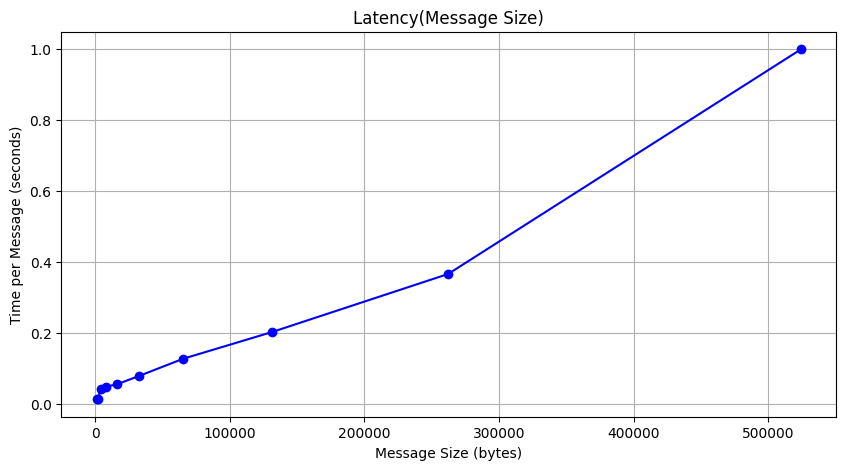

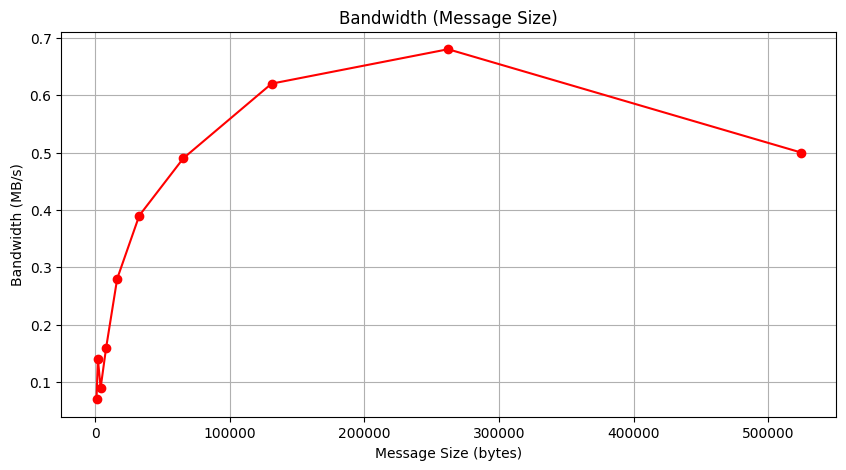

In [4]:
import matplotlib.pyplot as plt

# Given output
output = """
Number of passes	Size	Iterations	Total time	Time per message	Bandwidth
10000	1024	9765	132.933024	0.013613	0.07
10000	2048	4882	68.053644	0.013940	0.14
10000	4096	2441	101.418134	0.041548	0.09
10000	8192	1220	59.764468	0.048987	0.16
10000	16384	610	34.073971	0.055859	0.28
10000	32768	305	24.196849	0.079334	0.39
10000	65536	152	19.410849	0.127703	0.49
10000	131072	76	15.372100	0.202264	0.62
10000	262144	38	13.904337	0.365904	0.68
10000	524288	19	18.967874	0.998309	0.50
"""

# Initialize lists to store data
message_sizes = []
time_per_message = []
bandwidth = []

# Split the output by lines and skip the first line (header)
lines = output.strip().split('\n')[1:]

# Parse each line and extract the data
for line in lines:
    parts = line.split()
    message_sizes.append(int(parts[1]))
    time_per_message.append(float(parts[4]))
    bandwidth.append(float(parts[5]))

# Plotting latency
plt.figure(figsize=(10, 5))
plt.plot(message_sizes, time_per_message, marker='o', color='b')
plt.title('Latency(Message Size)')
plt.xlabel('Message Size (bytes)')
plt.ylabel('Time per Message (seconds)')
plt.grid(True)
# Save plot as PNG
plt.savefig('latency.png')
plt.show()

# Plotting bandwidth
plt.figure(figsize=(10, 5))
plt.plot(message_sizes, bandwidth, marker='o', color='r')
plt.title('Bandwidth (Message Size)')
plt.xlabel('Message Size (bytes)')
plt.ylabel('Bandwidth (MB/s)')
plt.grid(True)
# Save plot as PNG
plt.savefig('bandwidth.png')
plt.show()
